  # Test of hierarchical classification (model 2)
  
  
  This model uses four layers. In the first layer, every source is classified hierarchically as Stochastic, Transient or Periodic. Then, every source pass trough the next layers (Stochastic, Transient and Periodic). The final classification is dertermined by multiplying the probabilities of the first layer, with their correspondant probabilites of the Stochastic, Transient and Periodic layers. For instance, the probability of being RRL corresponds to the product of the probability of being periodic (according to the first layer) and the probability of being RRL (according to the periodic layer): 
 
 $$Prob_{final}(RRL) = Prob_{first \: layer}(Periodic)* Prob_{periodic \: layer}(RRL)$$
 
 And the probability of being a Blazar is computed as:
 
  $$Prob_{final}(Blazar) = Prob_{first \: layer}(Stochastic)* Prob_{stochastic \: layer}(Blazar)$$


 
 The final classification is definded by the maximum $Prob_{final}$
 


In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection, metrics, ensemble
import pickle
import itertools
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.ensemble import BalancedRandomForestClassifier as RandomForestClassifier
from scipy.stats import randint as sp_randint
from sklearn.utils import class_weight
import os

  ### Definition of names for plots and files

In [2]:

date = '20200609'


features_path = '/Users/psanchez/Documents/Postdoc/Alerce/new_DB/features/'

features_file = features_path+'features_for_ML_with_WISE.parquet'


class_output = '../ZTF_classifications/classes_BHRF_TSv7_original_hierarchical_classes_allprobs_'+date+'.csv'

#where the RF models are saved

model_first_layer = 'final_BHRF_model/hierarchical_level_RF_model.pkl'
model_periodic_layer = 'final_BHRF_model/periodic_level_RF_model.pkl'
model_transient_layer = 'final_BHRF_model/stockastic_level_RF_model.pkl'
model_stochastic_layer = 'final_BHRF_model/transient_level_RF_model.pkl'

features_pickle = 'final_BHRF_model/features_RF_model.pkl'    


### reading the training set files 

In [3]:
df_feat = pd.read_parquet(features_file)


#discarging infinite values
df_feat = df_feat.replace([np.inf, -np.inf], np.nan)

print(df_feat.head())

              MHAOV_Period_1  MHAOV_Period_2  Amplitude_1  Amplitude_2  \
oid                                                                      
ZTF17aaaaavn        0.106021        0.613572     0.078912     0.097860   
ZTF17aaaadjh        0.233443        0.233454     0.493980     0.463765   
ZTF17aaaadwo        0.060049        0.216873     0.090708     0.196542   
ZTF17aaaajjv      526.315748      555.555529     0.539600     0.566276   
ZTF17aaaakjt        0.148265        0.148265     0.564867     0.572449   

              AndersonDarling_1  AndersonDarling_2  Autocor_length_1  \
oid                                                                    
ZTF17aaaaavn           0.847902           0.673712               2.0   
ZTF17aaaadjh           1.000000           1.000000               1.0   
ZTF17aaaadwo           0.903625           0.993806               1.0   
ZTF17aaaajjv           1.000000           1.000000              14.0   
ZTF17aaaakjt           0.999907           0.99050

In [4]:
#defining columns excluded from the df_nd table

rm_nd_cols = [
'n_det_1',
'n_det_2',
'n_pos_1',
'n_pos_2',
'n_neg_1',
'n_neg_2',
'first_mag_1',
'first_mag_2',
'MHPS_non_zero_1',
'MHPS_non_zero_2',
'MHPS_PN_flag_1',
'MHPS_PN_flag_2',
'mean_mag_1',
'mean_mag_2',
'min_mag_1',
'min_mag_2',
'W1','W2','W3','W4',  
#'w1mpro', 'w2mpro', 'w3mpro', 'w4mpro',
#'w1mag', 'w2mag' ,'w3mag','w4mag',
'iqr_1',
'iqr_2', 
'delta_mjd_fid_1',
'delta_mjd_fid_2',
'last_mjd_before_fid_1',
'last_mjd_before_fid_2',
#'g-r_max_corr',
#'g-r_mean_corr',
#'g-r_mean',
'g-r_ml',
'MHAOV_Period_1', 'MHAOV_Period_2',
]



  ## Balanced random forest
  
  ### Loading each layer: Hierarchical, Periodic, Stochastic and Transient

In [5]:
#Loading RF models

rf_model_hierarchical = pd.read_pickle(model_first_layer )
rf_model_stochastic = pd.read_pickle(model_stochastic_layer)
rf_model_periodic = pd.read_pickle(model_periodic_layer)
rf_model_transient = pd.read_pickle(model_transient_layer)
feature_list = pd.read_pickle(features_pickle)



  ## Classifying unlabeled data

In [6]:
#loading the data
print(rm_nd_cols)

mean_drop = ['Mean_1','Mean_2']

df_feat_ul = df_feat.drop(rm_nd_cols, axis=1)
df_feat_ul = df_feat_ul.drop(mean_drop, axis=1)
df_feat_ul = df_feat_ul.replace([np.inf, -np.inf], np.nan)
df_feat_ul.fillna(-999,inplace=True)

df_feat_ul_out = df_feat_ul

df_feat_ul.head()

['n_det_1', 'n_det_2', 'n_pos_1', 'n_pos_2', 'n_neg_1', 'n_neg_2', 'first_mag_1', 'first_mag_2', 'MHPS_non_zero_1', 'MHPS_non_zero_2', 'MHPS_PN_flag_1', 'MHPS_PN_flag_2', 'mean_mag_1', 'mean_mag_2', 'min_mag_1', 'min_mag_2', 'W1', 'W2', 'W3', 'W4', 'iqr_1', 'iqr_2', 'delta_mjd_fid_1', 'delta_mjd_fid_2', 'last_mjd_before_fid_1', 'last_mjd_before_fid_2', 'g-r_ml', 'MHAOV_Period_1', 'MHAOV_Period_2']


,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,Con_2,...,rb,sgscore1,W1-W2,W2-W3,r-W3,r-W2,g-W3,g-W2,delta_period_1,delta_period_2
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aaaaavn,0.078912,0.097860,0.847902,0.673712,2.0,1.0,0.380952,0.428571,0.0,0.0,...,0.738809,0.989375,-0.301,1.491,4.239709,2.748709,5.350475,3.859475,0.017990,4.895612e-01
ZTF17aaaadjh,0.493980,0.463765,1.000000,1.000000,1.0,1.0,0.279070,0.293103,0.0,0.0,...,0.742857,1.000000,-0.125,2.380,4.533904,2.153904,5.281445,2.901445,0.000011,5.197596e-08
ZTF17aaaadwo,0.090708,0.196542,0.903625,0.993806,1.0,1.0,0.368421,0.285714,0.0,0.0,...,0.737143,0.992667,-0.065,1.602,4.344352,2.742352,5.495974,3.893974,0.423044,2.662193e-01
ZTF17aaaajjv,0.539600,0.566276,1.000000,1.000000,14.0,20.0,0.419580,0.481203,0.0,0.0,...,0.743333,1.000000,-0.040,0.997,7.765696,6.768696,10.193531,9.196531,29.239637,1.437226e-04
ZTF17aaaakjt,0.564867,0.572449,0.999907,0.990501,1.0,1.0,0.338462,0.350000,0.0,0.0,...,0.818571,0.975000,-0.027,0.027,3.161238,3.134238,4.298826,4.271826,0.000002,2.169809e-06


In [7]:
#predicting classes of unlabeled data

classes_order_proba_hierarchical = rf_model_hierarchical.classes_
classes_order_proba_periodic = rf_model_periodic.classes_
classes_order_proba_stochastic = rf_model_stochastic.classes_
classes_order_proba_transient = rf_model_transient.classes_



test_Y_hierarchical = rf_model_hierarchical.predict(df_feat_ul)
test_Y_proba_hierarchical = rf_model_hierarchical.predict_proba(df_feat_ul)

test_Y_periodic = rf_model_periodic.predict(df_feat_ul)
test_Y_proba_periodic = rf_model_periodic.predict_proba(df_feat_ul)

test_Y_stochastic = rf_model_stochastic.predict(df_feat_ul)
test_Y_proba_stochastic = rf_model_stochastic.predict_proba(df_feat_ul)

test_Y_transient = rf_model_transient.predict(df_feat_ul)
test_Y_proba_transient = rf_model_transient.predict_proba(df_feat_ul)




In [8]:
#multiplying probabilities
prob_periodic_ul = test_Y_proba_periodic*test_Y_proba_hierarchical[:,np.where(classes_order_proba_hierarchical=='Periodic')[0][0]].T[:, np.newaxis]
prob_stochastic_ul = test_Y_proba_stochastic*test_Y_proba_hierarchical[:,np.where(classes_order_proba_hierarchical=='Stochastic')[0][0]].T[:, np.newaxis]
prob_trainsient_ul = test_Y_proba_transient*test_Y_proba_hierarchical[:,np.where(classes_order_proba_hierarchical=='Transient')[0][0]].T[:, np.newaxis]

#obtaining final probabilities matrix
prob_final_ul = np.concatenate((prob_stochastic_ul,prob_trainsient_ul,prob_periodic_ul),axis=1)

print(np.sum(prob_final_ul,axis=1),np.mean(np.sum(prob_final_ul,axis=1)),np.std(np.sum(prob_final_ul,axis=1)))

#getting the ordered name of classes for prob_final
prob_final_class_names_ul = np.concatenate((classes_order_proba_stochastic,classes_order_proba_transient,classes_order_proba_periodic))
print(prob_final_class_names_ul)


class_final_proba_ul = np.amax(prob_final_ul,axis=1)
class_final_index_ul = np.argmax(prob_final_ul,axis=1)
class_final_name_ul = [prob_final_class_names_ul[x] for x in class_final_index_ul]


prob_org_ul =  np.concatenate((test_Y_proba_stochastic,test_Y_proba_transient,test_Y_proba_periodic),axis=1)



[1. 1. 1. ... 1. 1. 1.] 1.0 8.646543515627613e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']


In [9]:
#Writing results in the output
df_out = df_feat
print(df_out.shape)
print(len(class_final_name_ul))
print(len(prob_final_ul))


df_out['predicted_class'] = class_final_name_ul
df_out['predicted_class_proba'] = class_final_proba_ul
test_data_withclass = df_out


probs_header = prob_final_class_names_ul + '_prob'

prob_pd_ul = pd.DataFrame(prob_final_ul,columns=probs_header,index=df_out.index)

probs_org_header = prob_final_class_names_ul + '_prob_org' #original probabilities

prob_pd_ul_org = pd.DataFrame(prob_org_ul,columns=probs_org_header,index=df_out.index)

prob_h_pd_ul = pd.DataFrame(test_Y_proba_hierarchical, columns=['prob_Periodic','prob_Stochastic','prob_Transient'],index=df_out.index)

test_data_withclass = df_out.join(prob_pd_ul_org).join(prob_pd_ul).join(prob_h_pd_ul)

#test_data_withclass.to_csv(class_output)

test_data_withclass.head()


(868371, 183)
868371
868371


,MHAOV_Period_1,MHAOV_Period_2,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,...,SNIbc_prob,CEP_prob,DSCT_prob,E_prob,LPV_prob,Periodic-Other_prob,RRL_prob,prob_Periodic,prob_Stochastic,prob_Transient
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aaaaavn,0.106021,0.613572,0.078912,0.097860,0.847902,0.673712,2.0,1.0,0.380952,0.428571,...,0.003680,0.036504,0.018928,0.156832,0.021632,0.429936,0.012168,0.676,0.308,0.016
ZTF17aaaadjh,0.233443,0.233454,0.493980,0.463765,1.000000,1.000000,1.0,1.0,0.279070,0.293103,...,0.000000,0.096628,0.025636,0.658648,0.003944,0.047328,0.153816,0.986,0.014,0.000
ZTF17aaaadwo,0.060049,0.216873,0.090708,0.196542,0.903625,0.993806,1.0,1.0,0.368421,0.285714,...,0.000456,0.075164,0.019228,0.213256,0.013984,0.529644,0.022724,0.874,0.124,0.002
ZTF17aaaajjv,526.315748,555.555529,0.539600,0.566276,1.000000,1.000000,14.0,20.0,0.419580,0.481203,...,0.000624,0.001952,0.000000,0.000000,0.974048,0.000000,0.000000,0.976,0.020,0.004
ZTF17aaaakjt,0.148265,0.148265,0.564867,0.572449,0.999907,0.990501,1.0,1.0,0.338462,0.350000,...,0.000000,0.246784,0.023136,0.485856,0.009640,0.080976,0.117608,0.964,0.036,0.000


In [10]:
#test_data_withclass.to_csv(class_output)

Counter({'Periodic-Other': 243374, 'E': 198122, 'LPV': 161592, 'YSO': 85087, 'RRL': 58592, 'QSO': 43054, 'DSCT': 26672, 'CEP': 17307, 'AGN': 14342, 'CV/Nova': 7945, 'Blazar': 5085, 'SNIa': 3956, 'SNIbc': 1626, 'SNII': 890, 'SLSN': 727})
                number
Periodic-Other  243374
E               198122
LPV             161592
YSO              85087
RRL              58592
QSO              43054
DSCT             26672
CEP              17307
AGN              14342
CV/Nova           7945
Blazar            5085
SNIa              3956
SNIbc             1626
SNII               890
SLSN               727


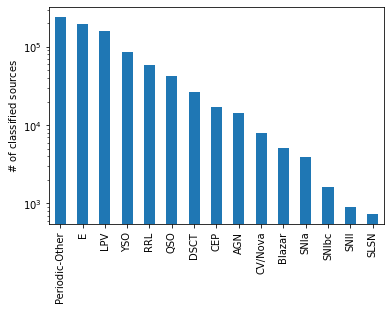

In [18]:
class_counts = Counter(class_final_name_ul)
class_counts.most_common()
print(class_counts)


df_hist = pd.DataFrame.from_dict(class_counts, orient='index',columns=['number'])
df_hist = df_hist.sort_values(by=['number'],ascending=False)
print(df_hist)
df_hist.plot(kind='bar',legend=False)

plt.yscale('log')
#plt.title('sources classified')
plt.ylabel(r'$\#$ of classified sources')

plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/number_classified_sources.pdf',bbox_inches='tight')

0 SNIa 0.962
1 SNIbc 0.906
2 SNII 0.9
3 SLSN 0.726
4 QSO 0.992
5 AGN 0.946
6 Blazar 0.862
7 YSO 0.44
8 CV/Nova 0.43
9 LPV 0.782
10 E 0.952
11 DSCT 0.912
12 RRL 0.966
13 CEP 0.882
14 Periodic-Other 0.788


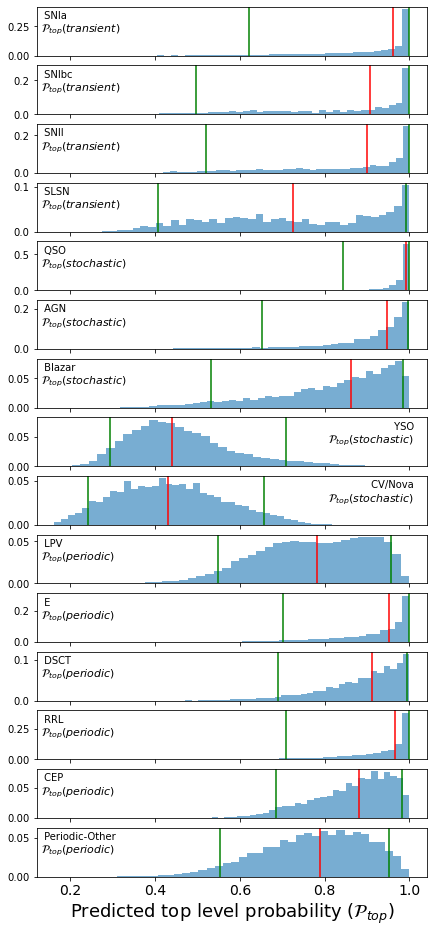

In [12]:
#plotting hierarchical level probabilities
label_order = ['SNIa', 'SNIbc', 'SNII', 'SLSN','QSO','AGN', 'Blazar', 'YSO','CV/Nova',
               'LPV', 'E', 'DSCT', 'RRL', 'CEP','Periodic-Other']

fig, ax = plt.subplots(nrows = len(prob_final_class_names_ul), figsize=(7, 16), sharex=True)
for idx, cl in enumerate(label_order):
   #print(idx, cl)
   if cl=="QSO" or cl=="AGN" or cl=='YSO' or cl=='CV/Nova' or cl=="Blazar":
        prob = 'prob_Stochastic'
   elif cl=="SNIa" or cl=="SNIbc" or cl=='SNII' or cl=='SLSN':
        prob = 'prob_Transient'
   else:      
        prob = 'prob_Periodic'
        
   print(idx, cl, np.percentile(test_data_withclass[prob][test_data_withclass['predicted_class']==cl].values, 50.))
   ax[idx].axvline(np.percentile(test_data_withclass[prob][test_data_withclass['predicted_class']==cl].values, 5.), c='g')
   ax[idx].axvline(np.percentile(test_data_withclass[prob][test_data_withclass['predicted_class']==cl].values, 50.), c='r')
   ax[idx].axvline(np.percentile(test_data_withclass[prob][test_data_withclass['predicted_class']==cl].values, 95.), c='g')
   weights = np.ones_like(test_data_withclass[prob][test_data_withclass['predicted_class']==cl].values)/float(len(test_data_withclass[prob][test_data_withclass['predicted_class']==cl].values))
   nn,binsn,aux=ax[idx].hist(test_data_withclass[prob][test_data_withclass['predicted_class']==cl].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='stepfilled', bins=40, lw=5, label=cl, alpha=0.6)
   if (cl=="YSO") or (cl=="CV/Nova")  : 
       ax[idx].text(1.01, np.amax(nn)*0.75, " %s" % (cl), fontsize=10, va='bottom', ha='right')
   else: 
       ax[idx].text(0.13, np.amax(nn)*0.75, " %s" % (cl), fontsize=10, va='bottom', ha='left')
        
   if (cl=="LPV") or (cl=="CEP") or (cl=="RRL") or (cl=="DSCT") or (cl=="Periodic-Other") or (cl=="E") : 
        ax[idx].text(0.13, np.amax(nn)*0.40, "$\mathcal{P}_{top}(periodic)$", fontsize=11, va='bottom', ha='left')


   elif (cl=="QSO") or (cl=="AGN") or (cl=="Blazar") : 
        ax[idx].text(0.13, np.amax(nn)*0.40, "$\mathcal{P}_{top}(stochastic)$", fontsize=11, va='bottom', ha='left')

   elif (cl=="YSO") or (cl=="CV/Nova") : 
        ax[idx].text(1.01, np.amax(nn)*0.40, "$\mathcal{P}_{top}(stochastic)$", fontsize=11, va='bottom', ha='right')



   else:
        ax[idx].text(0.13, np.amax(nn)*0.40, "$\mathcal{P}_{top}(transient)$" , fontsize=11, va='bottom', ha='left')


        
plt.xticks(fontsize = 14)

ax[len(label_order)-1].set_xlabel(r'Predicted top level probability ($\mathcal{P}_{top}}$)',fontsize=18)
plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/prob_dist_hierarchical_unlabeled_set.pdf',bbox_inches='tight')

0 SNIa 0.338602
1 SNIbc 0.299996
2 SNII 0.28302799999999995
3 SLSN 0.276012
4 QSO 0.711704
5 AGN 0.600588
6 Blazar 0.42681600000000003
7 YSO 0.350432
8 CV/Nova 0.26713200000000004
9 LPV 0.578022
10 E 0.44352
11 DSCT 0.34588399999999997
12 RRL 0.530944
13 CEP 0.327328
14 Periodic-Other 0.422912


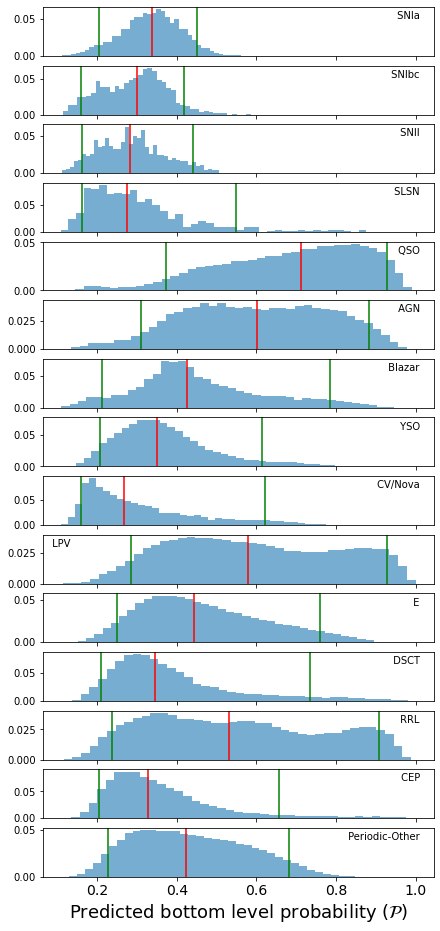

In [13]:
#plotting multi-class level probabilities

fig, ax = plt.subplots(nrows = len(prob_final_class_names_ul), figsize=(7, 16), sharex=True)
for idx, cl in enumerate(label_order):
   #print(idx, cl)
   print(idx, cl, np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 50.))
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 5.), c='g')
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 50.), c='r')
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 95.), c='g')
   weights = np.ones_like(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values)/float(len(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values))
   nn,binsn,aux=ax[idx].hist(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='stepfilled', bins=40, lw=5, label=cl, alpha=0.6)
   if (cl=="LPV"): 
       ax[idx].text(0.08, np.amax(nn)*0.75, " %s" % (cl), fontsize=10, va='bottom', ha='left')
   else: 
       ax[idx].text(1.01, np.amax(nn)*0.75, " %s" % (cl), fontsize=10, va='bottom', ha='right')

plt.xticks(fontsize = 14)

ax[len(label_order)-1].set_xlabel(r'Predicted bottom level probability ($\mathcal{P}$)',fontsize=18)
plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/prob_dist_unlabeled_set.pdf',bbox_inches='tight')

[ 0.28745954  0.01148621 -0.00761852 ...  0.07376862  0.05683932
  0.24931978]


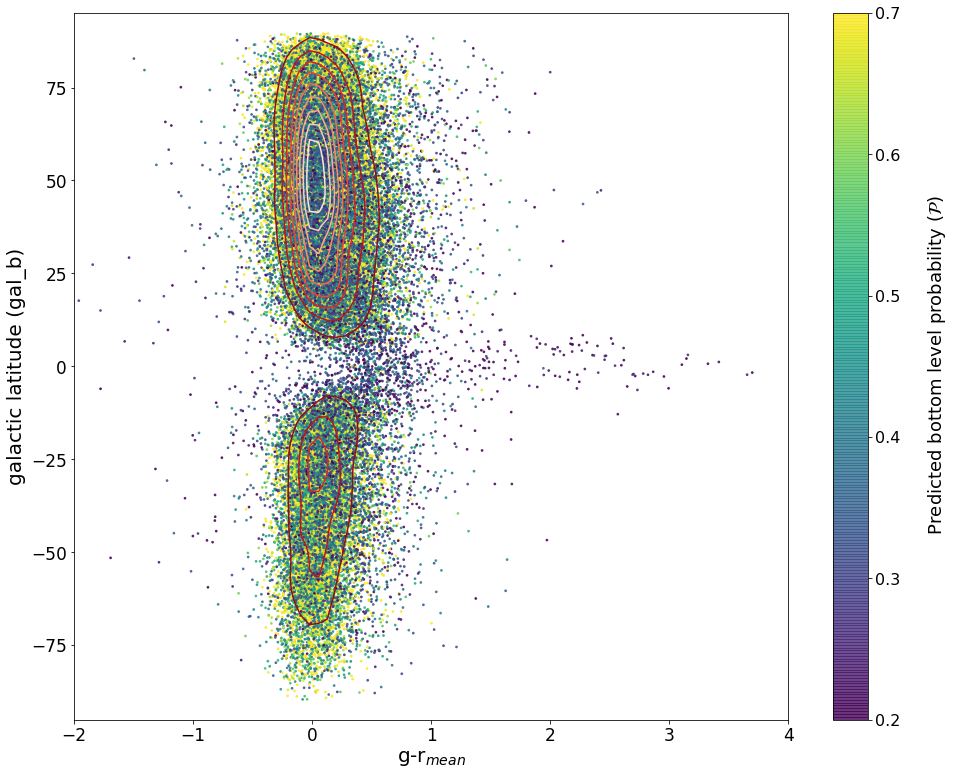

In [14]:
import matplotlib.cm as cm
import seaborn as sns

feature_x = 'g-r_mean'
feature_y = 'gal_b'
labels_list = ['QSO','AGN','Blazar','SLSN','SNII','SNIa','SNIbc']
logscale = False
colors = cm.rainbow(np.linspace(0, 1, len(labels_list)))
df_test = test_data_withclass.loc[(test_data_withclass[feature_y]>-999) & (test_data_withclass[feature_x]>-999)] 

fig, ax = plt.subplots(figsize=(16, 13))
ax.set_xlim(-2,4)

cm = plt.cm.get_cmap('viridis')

gal_b_list = []
color_list = []

for idx, cl in enumerate(labels_list):
   sc = ax.scatter(df_test[feature_x][df_test['predicted_class']==cl].values,df_test[feature_y][df_test['predicted_class']==cl].values,c=df_test['predicted_class_proba'][df_test['predicted_class']==cl].values,vmin=0.2, vmax=0.7,cmap=cm,alpha = 0.8, s = 3,label=cl)
   gal_b_list+=list(df_test[feature_y][df_test['predicted_class']==cl].values)
   color_list+=list(df_test[feature_x][df_test['predicted_class']==cl].values)
    
gal_b_array = np.array(gal_b_list)
color_array = np.array(color_list)

print(color_array)

ax = sns.kdeplot(color_array,gal_b_array, n_levels=10, cmap="Reds_r", shade=False)
    
cbar = plt.colorbar(sc)
cbar.set_label('\n Predicted bottom level probability ($\mathcal{P}$) ', rotation=90,fontsize=18)

#plt.legend(fontsize=15)
plt.xlabel(r'g-r$_{mean}$',fontsize=20)
plt.ylabel(r'galactic latitude (gal_b)',fontsize=20) 
plt.ylim(-95,95)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)

plt.gca().set_rasterized(True)
cbar.ax.set_yticklabels([0.2,0.3,0.4,0.5,0.6,0.7],fontsize=16)

plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/color_gal_b_selection_extragalactic.png',bbox_inches='tight',dpi=200)

[ 90.84914758  94.20044171 129.64863024 ... 147.90290087 128.77840965
 104.20778198]


/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:434: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


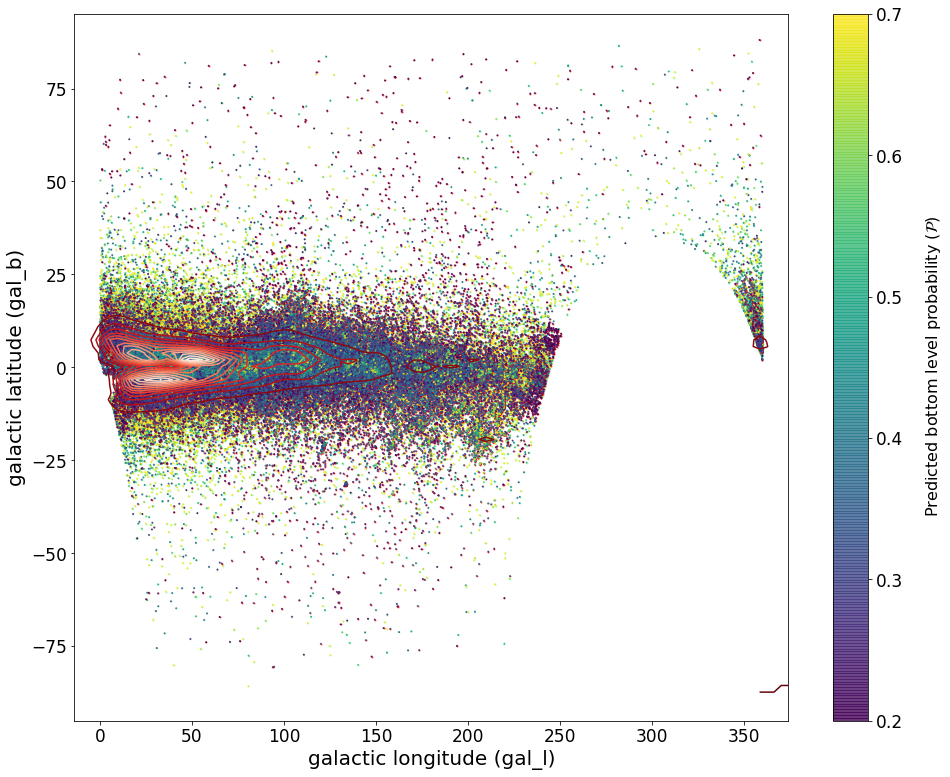

In [15]:
import matplotlib.cm as cm

feature_x = 'gal_l'
feature_y = 'gal_b'
labels_list = ['Ceph','LPV','YSO']
logscale = False
colors = cm.rainbow(np.linspace(0, 1, len(labels_list)))
df_test = test_data_withclass.loc[(test_data_withclass[feature_y]>-999) & (test_data_withclass[feature_x]>-999)] 

fig, ax = plt.subplots(figsize=(16, 13))
#ax.set_xlim(-2,4)

cm = plt.cm.get_cmap('viridis')

gal_b_list = []
gal_l_list = []


for idx, cl in enumerate(labels_list):
   ax.scatter(df_test[feature_x][df_test['predicted_class']==cl].values,df_test[feature_y][df_test['predicted_class']==cl].values,color=colors[idx],alpha = 0.65, s = 1,label=cl)
   sc = ax.scatter(df_test[feature_x][df_test['predicted_class']==cl].values,df_test[feature_y][df_test['predicted_class']==cl].values,c=df_test['predicted_class_proba'][df_test['predicted_class']==cl].values,vmin=0.2, vmax=0.7,cmap=cm,alpha = 0.8, s = 1,label=cl)
   ax.tick_params(labelsize=12)  
   gal_b_list+=list(df_test[feature_y][df_test['predicted_class']==cl].values)
   gal_l_list+=list(df_test[feature_x][df_test['predicted_class']==cl].values)
   

gal_b_array = np.array(gal_b_list)
gal_l_array = np.array(gal_l_list)

print(gal_l_array)

ax = sns.kdeplot(gal_l_array,gal_b_array, n_levels=15, cmap="Reds_r", shade=False, linewidth = 0.05)


cbar = plt.colorbar(sc)
cbar.set_label('\n Predicted bottom level probability ($\mathcal{P}$) ', rotation=90,fontsize=16)

#plt.legend(fontsize=15)
plt.xlabel(r'galactic longitude (gal_l)',fontsize=20)
plt.ylabel(r'galactic latitude (gal_b)',fontsize=20) 

plt.gca().set_rasterized(True)
cbar.ax.set_yticklabels([0.2,0.3,0.4,0.5,0.6,0.7],fontsize=17)
plt.ylim(-95,95)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)

plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/gal_l_gal_b_selection_galactic.png',bbox_inches='tight',dpi=200)

[177.64783496 181.92578411 198.1811498  ... 121.96778866 237.72013552
 129.68462631]


/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:434: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


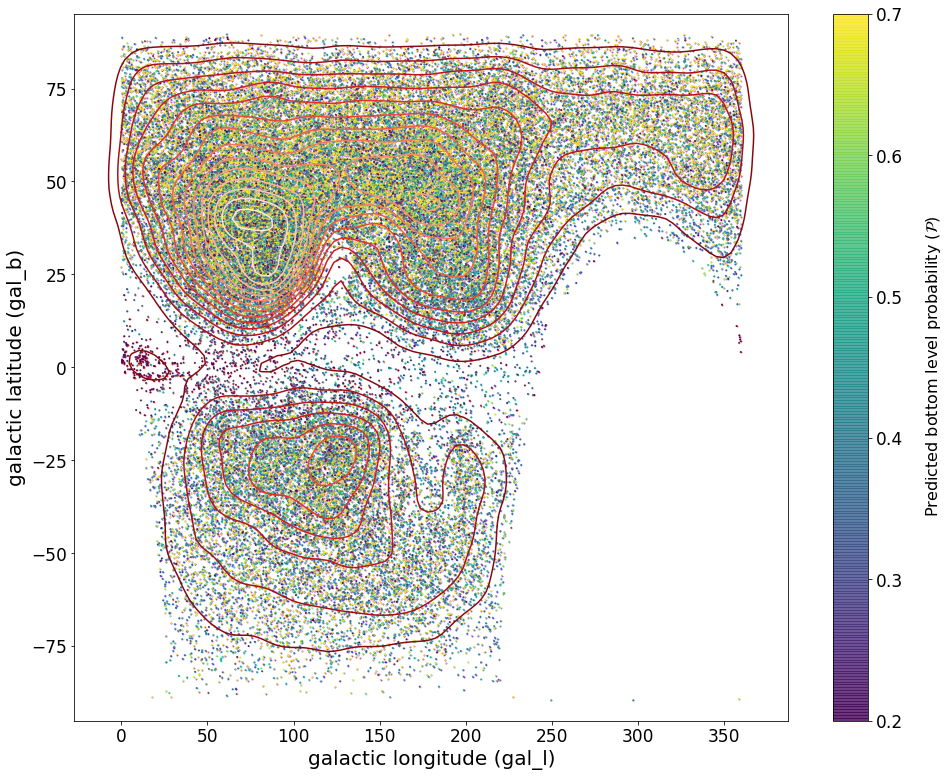

In [16]:
import matplotlib.cm as cm

feature_x = 'gal_l'
feature_y = 'gal_b'
labels_list = ['QSO','AGN','Blazar','SLSN','SNII','SNIa','SNIbc']
logscale = False
colors = cm.rainbow(np.linspace(0, 1, len(labels_list)))
df_test = test_data_withclass.loc[(test_data_withclass[feature_y]>-999) & (test_data_withclass[feature_x]>-999)] 

fig, ax = plt.subplots(figsize=(16, 13))
#ax.set_xlim(-2,4)

cm = plt.cm.get_cmap('viridis')

gal_b_list = []
gal_l_list = []


for idx, cl in enumerate(labels_list):
   ax.scatter(df_test[feature_x][df_test['predicted_class']==cl].values,df_test[feature_y][df_test['predicted_class']==cl].values,color=colors[idx],alpha = 0.65, s = 1,label=cl)
   sc = ax.scatter(df_test[feature_x][df_test['predicted_class']==cl].values,df_test[feature_y][df_test['predicted_class']==cl].values,c=df_test['predicted_class_proba'][df_test['predicted_class']==cl].values,vmin=0.2, vmax=0.7,cmap=cm,alpha = 0.8, s = 1,label=cl)
   ax.tick_params(labelsize=12)  
   gal_b_list+=list(df_test[feature_y][df_test['predicted_class']==cl].values)
   gal_l_list+=list(df_test[feature_x][df_test['predicted_class']==cl].values)
   

gal_b_array = np.array(gal_b_list)
gal_l_array = np.array(gal_l_list)

print(gal_l_array)

ax = sns.kdeplot(gal_l_array,gal_b_array, n_levels=15, cmap="Reds_r", shade=False, linewidth = 0.05)


cbar = plt.colorbar(sc)
cbar.set_label('\n Predicted bottom level probability ($\mathcal{P}$) ', rotation=90,fontsize=16)

#plt.legend(fontsize=15)
plt.xlabel(r'galactic longitude (gal_l)',fontsize=20)
plt.ylabel(r'galactic latitude (gal_b)',fontsize=20) 

plt.gca().set_rasterized(True)
cbar.ax.set_yticklabels([0.2,0.3,0.4,0.5,0.6,0.7],fontsize=17)
plt.ylim(-95,95)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)

plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/gal_l_gal_b_selection_extragalactic.png',bbox_inches='tight',dpi=200)

[-0.4        -0.33793103 -0.27586207 -0.2137931  -0.15172414 -0.08965517
 -0.02758621  0.03448276  0.09655172  0.15862069  0.22068966  0.28275862
  0.34482759  0.40689655  0.46896552  0.53103448  0.59310345  0.65517241
  0.71724138  0.77931034  0.84137931  0.90344828  0.96551724  1.02758621
  1.08965517  1.15172414  1.2137931   1.27586207  1.33793103  1.4       ]
[0.0005     0.00062351 0.00077754 0.00096961 0.00120914 0.00150783
 0.0018803  0.00234479 0.00292402 0.00364633 0.00454708 0.00567034
 0.00707107 0.00881782 0.01099607 0.01371241 0.01709976 0.02132388
 0.02659148 0.03316032 0.04135186 0.05156693 0.06430541 0.08019065
 0.1       ]
[0.0005     0.00062351 0.00077754 0.00096961 0.00120914 0.00150783
 0.0018803  0.00234479 0.00292402 0.00364633 0.00454708 0.00567034
 0.00707107 0.00881782 0.01099607 0.01371241 0.01709976 0.02132388
 0.02659148 0.03316032 0.04135186 0.05156693 0.06430541 0.08019065
 0.1       ]


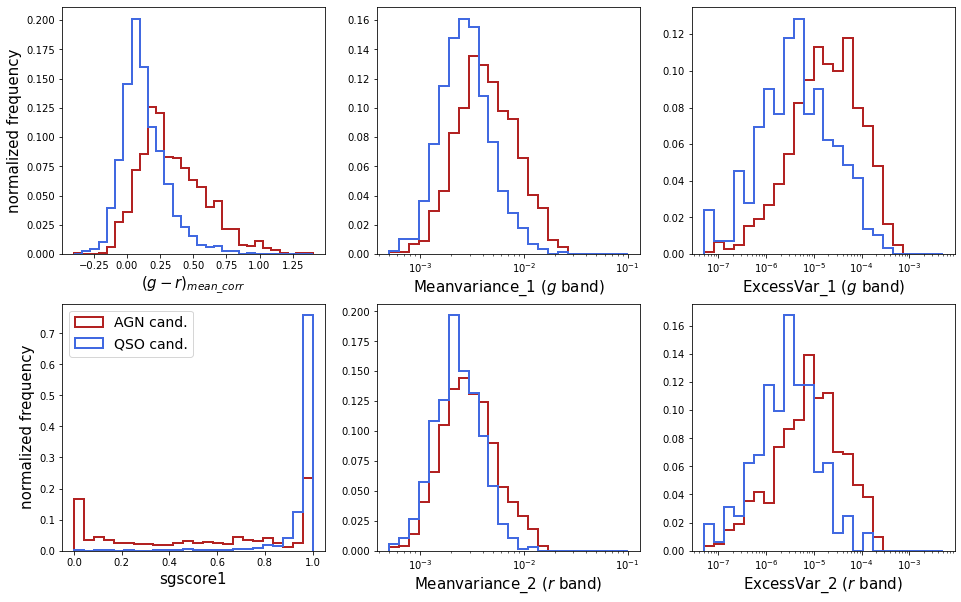

In [17]:
class_qso = '../ZTF_classifications/QSO_AGN_classifications_SIMBAD_as_seyfert_QSO_comparison.csv'

df_for_figures = pd.read_csv(class_qso,index_col='oid')

#print(df_for_figures)


fig, ax = plt.subplots(nrows=2, ncols= 3, figsize = (16,10)) 


feature='g-r_mean_corr'
bins_hist = np.linspace(-0.4,1.4,30)#np.logspace(np.log10(5e-8),np.log10(1000),25, base=10.0,endpoint=True)
df_for_figures_aux = df_for_figures[df_for_figures[feature]>=np.min(bins_hist)]
print(bins_hist)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='AGN'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='AGN'].values))
ax[0,0].hist(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='AGN'].values,  weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "firebrick", ec="firebrick",label='AGN cand.', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='QSO'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='QSO'].values))
ax[0,0].hist(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='QSO'].values,  weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "royalblue", ec="royalblue",label='QSO cand.', alpha=1.0)

ax[0,0].set_xlabel(r'$(g-r)_{mean\_corr}$',fontsize=15)
ax[0,0].set_ylabel(r'normalized frequency',fontsize=15)

feature='Meanvariance_1'
bins_hist = np.logspace(np.log10(5e-4),np.log10(0.1),25, base=10.0,endpoint=True)
df_for_figures_aux = df_for_figures[df_for_figures[feature]>=np.min(bins_hist)]
print(bins_hist)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='AGN'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='AGN'].values))
ax[0,1].hist(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='AGN'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "firebrick", ec="firebrick",label='AGN cand.', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='QSO'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='QSO'].values))
ax[0,1].hist(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='QSO'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "royalblue", ec="royalblue",label='QSO cand.', alpha=1.0)

ax[0,1].set_xlabel(r'Meanvariance_1 ($g$ band)',fontsize=15)
#ax[0,1].set_ylabel(r'normailized frequency',fontsize=15)
ax[0,1].set_xscale('log')

feature='Meanvariance_2'
bins_hist = np.logspace(np.log10(5e-4),np.log10(0.1),25, base=10.0,endpoint=True)
df_for_figures_aux = df_for_figures[df_for_figures[feature]>=np.min(bins_hist)]
print(bins_hist)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='AGN'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='AGN'].values))
ax[1,1].hist(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='AGN'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "firebrick", ec="firebrick",label='AGN cand.', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='QSO'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='QSO'].values))
ax[1,1].hist(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='QSO'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "royalblue", ec="royalblue",label='QSO cand.', alpha=1.0)

ax[1,1].set_xlabel(r'Meanvariance_2 ($r$ band)',fontsize=15)
#ax[1,1].set_ylabel(r'normailized frequency',fontsize=15)
ax[1,1].set_xscale('log')

feature='ExcessVar_1'
bins_hist = np.logspace(np.log10(5e-8),np.log10(0.005),25, base=10.0,endpoint=True)
df_for_figures_aux = df_for_figures[df_for_figures[feature]>=np.min(bins_hist)]
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='AGN'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='AGN'].values))
ax[0,2].hist(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='AGN'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "firebrick", ec="firebrick",label='AGN cand.', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='QSO'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='QSO'].values))
ax[0,2].hist(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='QSO'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "royalblue", ec="royalblue",label='QSO cand.', alpha=1.0)

ax[0,2].set_xlabel(r'ExcessVar_1 ($g$ band)',fontsize=15)
#ax[0,2].set_ylabel(r'normailized frequency',fontsize=15)
ax[0,2].set_xscale('log')

feature='ExcessVar_2'
bins_hist = np.logspace(np.log10(5e-8),np.log10(0.005),25, base=10.0,endpoint=True)
df_for_figures_aux = df_for_figures[df_for_figures[feature]>=np.min(bins_hist)]
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='AGN'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='AGN'].values))
ax[1,2].hist(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='AGN'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "firebrick", ec="firebrick",label='AGN cand.', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='QSO'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='QSO'].values))
ax[1,2].hist(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='QSO'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "royalblue", ec="royalblue",label='QSO cand.', alpha=1.0)

ax[1,2].set_xlabel(r'ExcessVar_2 ($r$ band)',fontsize=15)
#ax[1,2].set_ylabel(r'normailized frequency',fontsize=15)
ax[1,2].set_xscale('log')


feature='sgscore1'
bins_hist = np.linspace(0,1,25,endpoint=True)#np.logspace(np.log10(2e-4),np.log10(1500),25, base=10.0,endpoint=True)
df_for_figures_aux = df_for_figures[df_for_figures[feature]>=np.min(bins_hist)]
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='AGN'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='AGN'].values))
ax[1,0].hist(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='AGN'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "firebrick", ec="firebrick",label='AGN cand.', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='QSO'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='QSO'].values))
ax[1,0].hist(df_for_figures_aux[feature][df_for_figures_aux['predicted_class']=='QSO'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "royalblue", ec="royalblue",label='QSO cand.', alpha=1.0)

ax[1,0].legend(loc='upper left',fontsize=14)
ax[1,0].set_xlabel(r'sgscore1',fontsize=15)
ax[1,0].set_ylabel(r'normalized frequency',fontsize=15)

plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/QSO_as_QSO_or_AGN.pdf',bbox_inches='tight')


